# Evaluate

In this notebook we evaluate the accuracy of the predicted alignments.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle
from plotnine import *
from pandas.api.types import CategoricalDtype

In [3]:
TRAIN_SET = 'toy'

In [4]:
ANNOTATIONS_ROOT = Path('../ttmp/Chopin_Mazurkas_Modified/annotations_beat')
query_list = Path(f'cfg_files/queries.train.{TRAIN_SET}')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [5]:
def eval_dir(hypdir, querylist, annot_root_1, annot_root_2, hop_sec, savefile = None):
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, annot_root_1, annot_root_2, hop_sec)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [6]:
def eval_file(hypfile, annot_root_1, annot_root_2, hop_sec):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (annot_root_1 / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (annot_root_2 / piece / parts[1]).with_suffix('.beat')
    
    gt1, gt2 = getTimestamps(annotfile1, annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames

    if hypalign is None:
        err = np.array(np.ones(gt1.shape) * np.inf)
#         err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [7]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [8]:
def getTimestamps(annotfile1, annotfile2):
    df1 = pd.read_csv(annotfile1, header=None, sep='\s+', skiprows=3) 
    df2 = pd.read_csv(annotfile2, header=None, sep='\s+', skiprows=3)
    
    df_merged = pd.merge(df1, df2, on=[2], how='inner')

    return df_merged['0_x'], df_merged['0_y']

In [9]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Evaluate all hypothesis directories.

In [10]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir, system, benchmark):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    if benchmark == 'partialOverlap':
        annot_root_1 = Path(f'../ttmp/Chopin_Mazurkas_Benchmarks/partialStart/annotations_beat')
        annot_root_2 = Path(f'../ttmp/Chopin_Mazurkas_Benchmarks/partialEnd/annotations_beat')
    elif 'preA_postB' in benchmark:
        sec = benchmark.split('_')[-1]
        annot_root_1 = Path(f'../ttmp/Chopin_Mazurkas_Benchmarks/pre_{sec}/annotations_beat')
        annot_root_2 = Path(f'../ttmp/Chopin_Mazurkas_Benchmarks/post_{sec}/annotations_beat')
    elif benchmark == 'matching':
        annot_root_1 = Path(f'../ttmp/Chopin_Mazurkas_Modified/annotations_beat')
        annot_root_2 = Path(f'../ttmp/Chopin_Mazurkas_Modified/annotations_beat')
    else:
        annot_root_1 = Path(f'../ttmp/Chopin_Mazurkas_Benchmarks/{benchmark}/annotations_beat')
        annot_root_2 = Path(f'../ttmp/Chopin_Mazurkas_Modified/annotations_beat')
    for hypdir in glob.glob(f'{rootdir}/{benchmark}/{system}'):
        outpath = outdir + '/' + f'{benchmark}'
        Path(outpath).mkdir(parents=True, exist_ok=True)
        savefile = outpath + '/' + os.path.basename(hypdir) + '.pkl'
        allErrs = eval_dir(hypdir, querylist, annot_root_1, annot_root_2, hop_sec, savefile = savefile)

**Evaluate on Train Data**

In [11]:
EXPERIMENTS_ROOT = f'experiments_train/{TRAIN_SET}'
hop_sec = 512 * 1 / 22050
outdir = f'evaluations_train/{TRAIN_SET}'
Path(outdir).mkdir(parents=True, exist_ok=True)

In [12]:
def eval_benchmark(experiments_root, hop_sec, outdir, system, benchmark):
    eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir, system, benchmark)

In [13]:
SYSTEMS = ['DTW1', 'DTW2', 'DTW3', 'DTW4', 'SubseqDTW1', 'SubseqDTW2', 'SubseqDTW3', 'NWTW', 'DTWStarv02']
BENCHMARKS = ['Matching', 'Subseq20', 'Subseq30', 'Subseq40', 'PartialStart', 'PartialEnd', 'PartialOverlap', 
              'Pre_5', 'Pre_10', 'Pre_20', 'Post_5', 'Post_10', 'Post_20', 'PreA_PostB_5', 
              'PreA_PostB_10', 'PreA_PostB_20']

In [14]:
systems = [system.lower() for system in SYSTEMS]
benchmarks = []
for benchmark in BENCHMARKS:
    if benchmark == 'PartialOverlap':
        benchmarks.append('partialOverlap')
    elif benchmark == 'PartialStart':
        benchmarks.append('partialStart')
    elif benchmark == 'PartialEnd':
        benchmarks.append('partialEnd')
    elif 'PreA_PostB' in benchmark:
        sec = benchmark.split('_')[-1]
        benchmarks.append(f'preA_postB_{sec}')
    else:
        benchmarks.append(benchmark.lower())

In [15]:
def eval_all_benchmarks(experiments_root, hop_sec, outdir, systems, benchmarks):
    for benchmark in benchmarks:
        for system in systems:
            eval_benchmark(experiments_root, hop_sec, outdir, system, benchmark)          

In [16]:
eval_all_benchmarks(EXPERIMENTS_ROOT, hop_sec, outdir, systems, benchmarks)

Processing experiments_train/toy/matching/dtw1  done
Processing experiments_train/toy/matching/dtw2  done
Processing experiments_train/toy/matching/dtw3  done
Processing experiments_train/toy/matching/dtw4  done
Processing experiments_train/toy/matching/subseqdtw1  done
Processing experiments_train/toy/matching/subseqdtw2  done
Processing experiments_train/toy/matching/subseqdtw3  done
Processing experiments_train/toy/matching/nwtw  done
Processing experiments_train/toy/matching/dtwstarv02  done
Processing experiments_train/toy/subseq20/dtw1  done
Processing experiments_train/toy/subseq20/dtw2  done
Processing experiments_train/toy/subseq20/dtw3  done
Processing experiments_train/toy/subseq20/dtw4  done
Processing experiments_train/toy/subseq20/subseqdtw1  done
Processing experiments_train/toy/subseq20/subseqdtw2  done
Processing experiments_train/toy/subseq20/subseqdtw3  done
Processing experiments_train/toy/subseq20/nwtw  done
Processing experiments_train/toy/subseq20/dtwstarv02  don

### Plot error vs tolerance

In [17]:
def calc_error_rates(errFile, maxTol):
    
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [18]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [19]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

**Evaluate on Train Data**

In [20]:
EVAL_ROOT_DIR = f'evaluations_train/{TRAIN_SET}'
toPlot = []

for benchmark in benchmarks:
    for system in systems:
        toPlot.append(f'{benchmark}/{system}')
maxTol = 1000 # in msec

In [21]:
def get_errs(eval_root_dir, toPlot, maxTol):
    errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)
    return errRates, errVals

In [22]:
errRates, errVals = get_errs(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates ................................................................................................................................................ done


In [23]:
# plot_multiple_roc(errRates, toPlot)

In [24]:
errRates.shape[0] == len(SYSTEMS) * len(BENCHMARKS)

True

### Make Plots (New)

In [25]:
def make_df(time, errRates):
    data = {}
    
    num_systems = len(SYSTEMS)
    num_benchmarks = len(BENCHMARKS)
    
    data['Benchmark'] = []
    for benchmark in BENCHMARKS:
        data['Benchmark'] += [benchmark] * num_systems
    
    data['System'] = [system for system in SYSTEMS] * num_benchmarks

    data['Error'] = []
    for i in range(num_benchmarks*num_systems):
            data['Error'].append(errRates[i][time]*100)

    df = pd.DataFrame.from_dict(data)
    benchmark_categories = CategoricalDtype(categories=BENCHMARKS, ordered=True)
    df.Benchmark = df.Benchmark.astype(benchmark_categories)
    system_categories = CategoricalDtype(categories=SYSTEMS, ordered=True)
    df.System = df.System.astype(system_categories)
    
    return df

In [26]:
ms200_df = make_df(200, errRates)

In [27]:
colors = ['#00876c','#53a372','#8bbf7a','#c4d985','#fff197','#fbc771','#f49c59','#e86e50','#d43d51']
#d06363
#e58864
#f1af6d
#f7d782
#f6ffa5
#c1f6ac
#90e9b9
#65dac7
#48c8d0
ms100_df = make_df(100, errRates)
ms500_df = make_df(500, errRates)

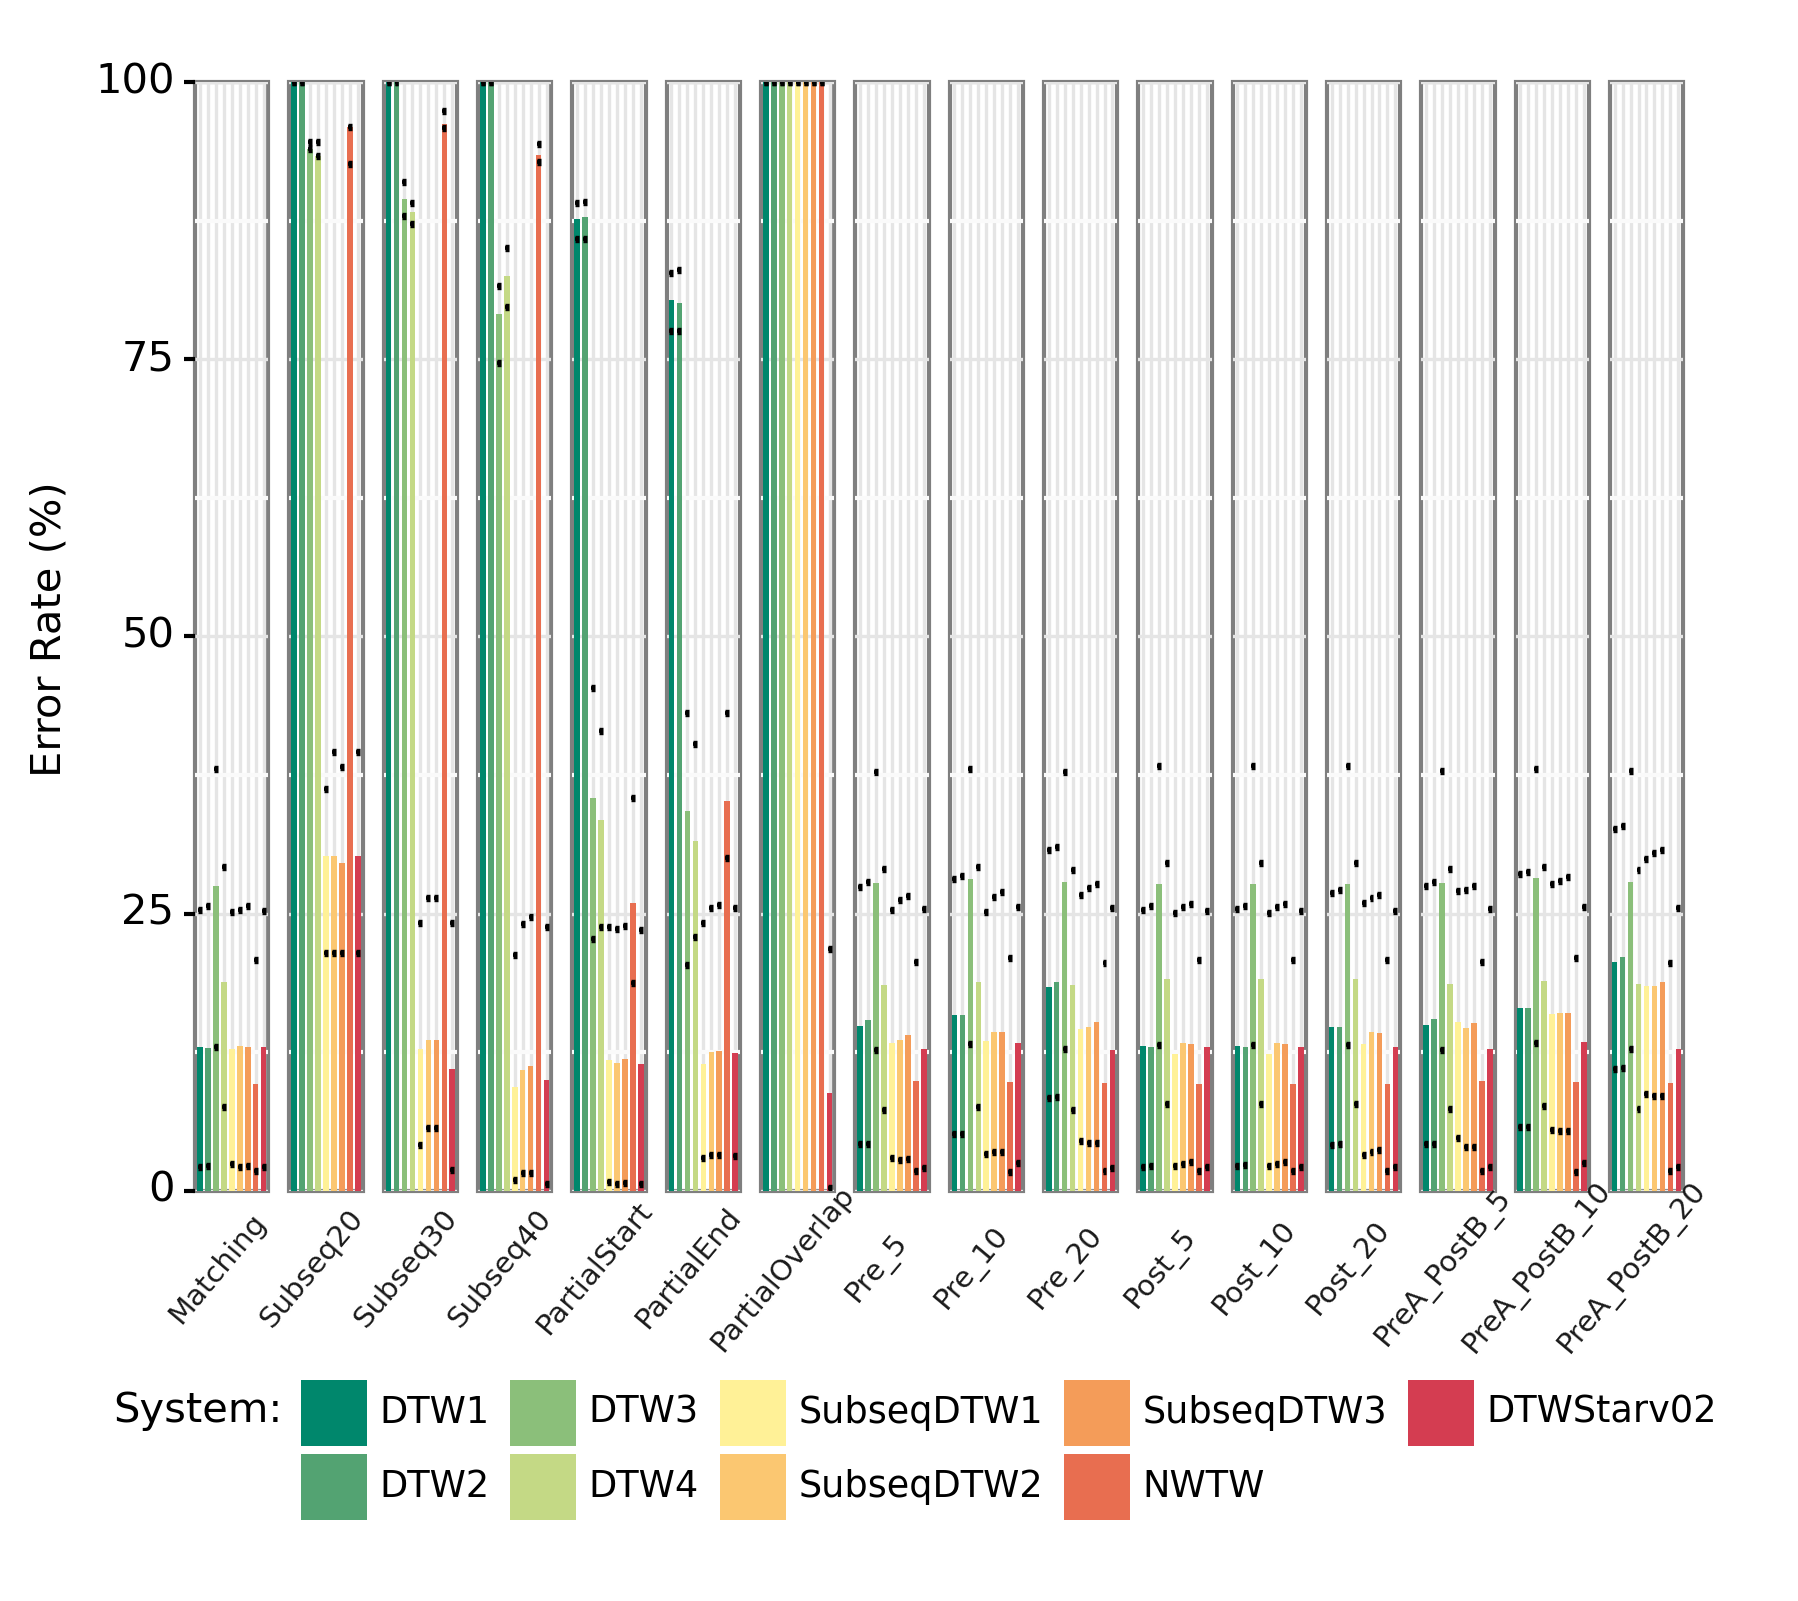

<ggplot: (8744614884337)>

In [28]:
(ggplot(ms200_df, aes(x="System", y="Error", fill="System")) +
    geom_bar(width = 0.7, position=position_dodge2(preserve='single', width=0.2), stat='identity') +
    scale_y_continuous(expand = [0, 0], limits = [0, 100]) +
    scale_fill_manual(values=colors) +
    geom_crossbar(ms100_df, aes(ymin="Error", ymax="Error")) +
    geom_crossbar(ms500_df, aes(ymin="Error", ymax="Error")) +
    facet_grid('. ~ Benchmark') +
    theme_bw() + 
    labs(y = "Error Rate (%)") +
    theme(dpi=300, legend_position=(0.5, -0.07), legend_direction="horizontal", legend_title_align='bottom', 
            legend_background = element_blank(),
            legend_title = element_text(size=10),
            strip_background = element_blank(),
            strip_text_x = element_text(angle = 50, size=7, position=(0.3, -0.07)),
            axis_text_x = element_blank(),
            axis_ticks_major_x = element_blank(),
            axis_text_y = element_text(size = 10, colour='black'), 
            axis_title_x = element_blank(),
            axis_title_y = element_text(size = 10, margin={'r': 6.0})) +
    guides(fill=guide_legend(title="System:", title_position='left', label_position="right", override_aes = {'size': 0})))
